### 整体思路
1. 使用sin函数关系加上正态分布的噪声重复生成数据
2. 对生成的每一组数据做回归 尝试用多项式回归
3. 对生成的结果计算bias和variance
4. 可视化

In [15]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from numpy.linalg import cholesky

### 生成模拟数据

In [16]:
sigma = 0.1
def sin_data_gen(start = 0, end = 2 * np.pi, step = 0.1, sigma = sigma):
    x = np.arange(start, end, step)
    y = np.sin(x) + np.random.normal(0, sigma, len(x))
    return x, y

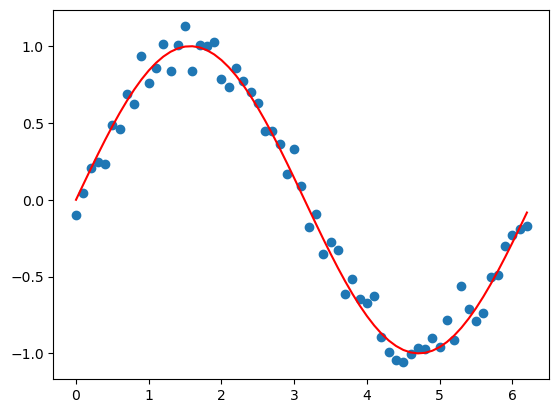

In [17]:
# 绘制正弦函数图像和数据点
import matplotlib.pyplot as plt
x, y = sin_data_gen()
plt.plot(x, y, 'o')
plt.plot(x, np.sin(x), 'r')
plt.show()

### 对模拟数据进行多项式回归

#### 尝试手动实现回归

In [19]:
def gen_polynomial_feature(X, degree):
    """
    将原始特征转换为多项式特征
    
    参数:
    X: 原始输入特征，例如[2, 3]
    degree: 多项式次数, 例如2
    
    返回:
    多项式特征矩阵，例如[[1, 2, 4], [1, 3, 9]]
    """
    X_feature = np.zeros((len(X), degree)) # 输入矩阵的大小应该是 n * (degree + 1)
    for i in range(1, degree + 1):
        X_feature[:, i - 1] = X ** i
    X_feature = sm.add_constant(X_feature, has_constant='add')
    """
    has_constant='add'必须要加上
    否则在X_feature里有两列完全一样/X_feature里只有一行的情况下无法正常加上常数1

    更保守的写法：
    X_feature = np.zeros((len(X), degree + 1))  # 包含常数项的矩阵
    X_feature[:, 0] = 1  # 常数项
    for i in range(1, degree + 1):
        X_feature[:, i] = X ** i
    return X_feature
    """
    return X_feature

print(gen_polynomial_feature(np.array([2, 2]), 2))

[[1. 2. 4.]
 [1. 2. 4.]]


In [20]:
def solve_coefficient(X, y):
    """
    求解多项式回归系数 cholesky 分解法
    
    参数:
    X: array-like, shape (n_samples, degree + 1)
        输入特征
    y: array-like, shape (n_samples,)
        目标值
        
    返回:
    coef: array-like, shape (degree + 1,)
        多项式回归系数
    """

    XTX = np.dot(X.T, X)
    XTy = np.dot(X.T, y)
    L = cholesky(XTX)
    b1 = np.linalg.solve(L, XTy)
    coef = np.linalg.solve(L.T, b1)
    return coef

    # 如果矩阵不是正定的,使用伪逆求解
    # return np.linalg.pinv(XTX).dot(XTy)

In [21]:
def predict_point(coef, point):
    """
    预测单个数据点
    
    参数:
    coef: array-like, shape (degree + 1,)
        多项式回归系数
    point: float
        输入特征
        
    返回:
    y_pred: float
        预测值
    """
    point_feature = np.array([point ** i for i in range(len(coef))])
    y_pred = np.dot(coef, point_feature)
    return y_pred

In [22]:
def polynomial_regression_manual(X, y, degree=1, point=np.pi):
    """
    手动实现多项式回归
    
    步骤1: 特征变换 gen_polynomial_feature函数
    - 将原始特征X转换为多项式特征矩阵
    - 形如 [1, x, x², x³, ...]
    
    步骤2: 求解系数 solve_coefficient函数
    - 使用正规方程 w = (X^T X)^(-1) X^T y
    - 或使用梯度下降迭代求解
    
    步骤3: 预测 predict_point函数
    - 用求得的系数对point做预测
    - 需要先将point转换为多项式形式
    """
    X_feature = gen_polynomial_feature(X, degree)
    coef = solve_coefficient(X_feature, y)
    y_pred = predict_point(coef, point)
    return y_pred

### 模拟重复生成数据-回归的过程

In [23]:
def simulation(n = 100, degree = 3, point = np.pi, **kwargs_data_gen):
    """
    模拟重复回归的过程
    
    n : int, default=100
        模拟次数
    
    返回 : y_pre_list
        n次预测的值的列表

    **kwargs_data_gen : dict
        传递给 sin_data_gen 的参数:
        - start : float, default=0
        - end : float, default=2*np.pi
        - step : float, default=0.1
        - sigma : float, default=0.1

    流程 : 生成数据-回归-预测某点处的值-返回n次预测的值的列表
    """
    y_pre_list = []
    for _ in range(n + 1):
        X, y = sin_data_gen(**kwargs_data_gen)
        y_pre = polynomial_regression_manual(X, y, degree, point)
        y_pre_list.append(y_pre)

    return y_pre_list

### 使用模拟结果计算参数并可视化

In [24]:
def plot_simulation():
    bias2 = []
    Var_f = []
    err = []
    for degree in range(1, 11):
        y_pre_list = simulation(degree=degree)
        E_f = np.mean(y_pre_list)
        Var_f.append(np.var(y_pre_list))
        bias2.append((np.sin(np.pi) - E_f) ** 2)
        err.append(np.var(y_pre_list) + (np.sin(np.pi) - E_f) ** 2 + sigma ** 2)
    
    # 绘制误差图像
    plt.plot(range(1, 11), bias2, label='bias^2')
    plt.plot(range(1, 11), Var_f, label='Var')
    # plt.plot(range(1, 11), err, label='error')
    plt.legend()
    plt.show()

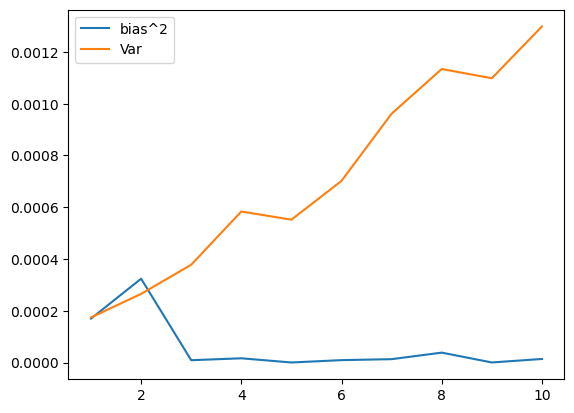

In [25]:
plot_simulation()